# Monochromator
* ## Calibration
* ## Influence of slit widths tested.
* ## Upper boundary of detection for photo multiplier
* ## Detection probability of polarized light
* ## Spectra of the following samples: CS$_2$, CHCl$_3$, CCl$_4$

Fits are not possible due to the restricted resolution (one point each 0.1 nm).
For callibration, we search for local minima. 

Detection prob. can only be interpolated, as measurement at 45 deg is missing. 

Peaks in spectra are small compared to noise. No fits done yet.

Sulfur is not measured.

In [1]:
# %load ../../style.py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit
sns.set(style='ticks', palette='Set2') 
sns.despine()

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['axes.titlesize'] = fontsize_labels
xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  


In [40]:
from smooth import savitzky_golay
import uncertainties as uc
import uncertainties.unumpy as un

plt.close("all")
show_fig = True
save_fig = True # see below
if not save_fig:
        rcParams['figure.figsize'] = (13, 8)  

npy_dir = "./npy/"
fig_dir = './figures/'


color_names = ['windows blue', "pale red", "faded green", "amber", 
          'dark green', 'dark fuchsia', 'browny orange', 
          'puke green', 'dark royal blue', 'dusty purple', 'red orange']
colors = sns.xkcd_palette(color_names)

xlim_global = (400, 600)
sx0_global = 0.2

In [3]:
def breit_wigner(x, x0, gamma, amplitude, offset):
    """
    Breit-Wigner or Cauchy distribution with location parameter x0 
    and scale parameter gamma = 0.5 * FWHM. Amplitude: 1 / (Pi * gamma). 
    No mean, variance or higher moments exist.
    """
    return amplitude / ((np.pi*gamma) * (1 + ((x - x0) / gamma)**2)) + offset
   
def bw_fit(x, y_e, x_range, p0, fit=True):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = un.nominal_values(y_e[mask])
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    
    if fit:
        coeff, cov = curve_fit(breit_wigner, x_fit, y_fit, p0=p0, 
                                  sigma=y_sigma, absolute_sigma=True)
        c = uc.correlated_values(coeff, cov)
        fit_peak = breit_wigner(x_fit, *coeff)
    else:
        fit_peak = breit_wigner(x_fit, *p0)
        c = un.uarray(p0, [0, 0, 0, 0])
    
    return x_fit, fit_peak, c

def linear(x, a, b):
    return (a*x + b)

In [4]:
def lamb_to_cm(lamb_stokes):
    """
    Converts Raman peaks in nm into wavenumber (in cm^-1) of corresponding vibrational mode
    """
    #lamb_laser = 532 # nm, Nd:Yag frequency doubled
    lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0] # measured laser wavelength
    dnu_cm = abs(1 / lamb_laser - 1 / lamb_stokes) * 10**7
    return(dnu_cm)

def cm_to_lamb(dnu_cm):
    """
    Converts  wavenumber (in cm^-1) of vibrational mode into corresponding Stokes peak in nm (for Nd:Yag laser)
    """
    #lamb_laser = 532 # nm, Nd:Yag frequency doubled
    lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0] # measured laser wavelength
    lamb_stokes = 1 / (1 / lamb_laser - dnu_cm * 10**-7) 
    return(lamb_stokes)

In [5]:
def uc_str(c):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    * as integers with max 4 error digits
    * as floats with max 3 error digits
    * as exp else
    """
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < 5): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

## Calibration

/usr/lib/python3/dist-packages/matplotlib/axes.py:4749: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


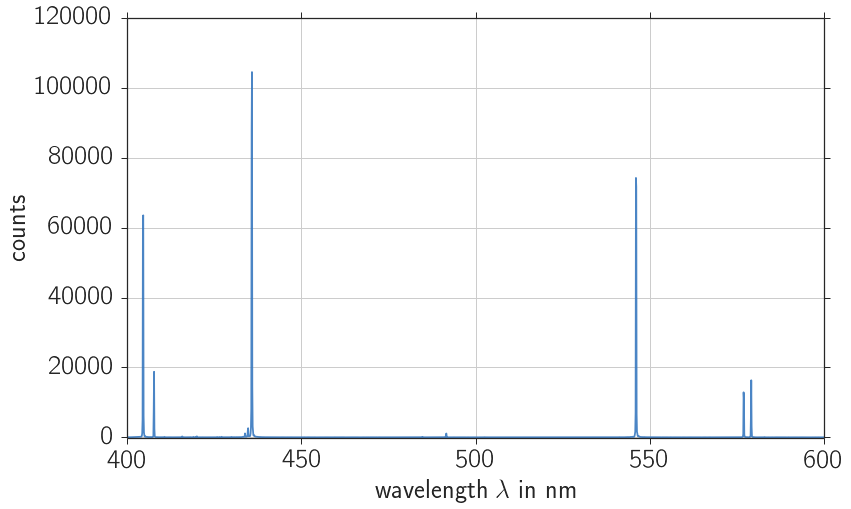

In [32]:
filename = "mono_hg"
x = np.load("npy/"+filename+"_lamb.npy") / 10 
y = np.load("npy/"+filename+"_count.npy")
y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))

# Peaks: Hg peaks: 404.7, 407.8, 435.8, 546.1, 577.1, 579.1 nm
# Fits do not converge. We search for local maxima in the predefined ranges. 
# Errors are set to 0.2 nm, twice the resolution of the data. 
x_ranges = [[402, 406],
            [406, 410], 
            [430, 440], 
            [540, 550], 
            [570, 578], 
            [578, 584]]
labels = ['404.7 nm', '407.8 nm', '435.8 nm', '546.1 nm', '577.1 nm', '579.1 nm']
x0s = []
for i, x_range, label in zip(range(len(x_ranges)), x_ranges, labels):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    x0 = x_fit[np.argmax(y_fit)]
    x0s.append(uc.ufloat(x0, sx0_global))

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('Calibration of Monochromator: Hg spectrum')
ax.plot(x, y, "-", alpha = 0.9, c=colors[0])
ax.set_xlim(xlim_global)
ax.set_ylim(-100, )
ax.set_xlabel("wavelength $\lambda$ in nm")
ax.set_ylabel('counts')
ax.grid(True)
ax.legend(loc='best')

if save_fig:
    file_name = "mono_calibration_hg"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

# Print results to latex table
lits = [404.7, 407.8, 435.8, 546.1, 577.1, 579.1]
i=0
for x0, lit in zip(x0s, lits):
    i += 1
    print("\cellcolor{LightCyan}$%i$ & $%s$ & $%.1f$   \\\\"%(
            i, uc_str(x0), lit))

### Calibration: Linear fit

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


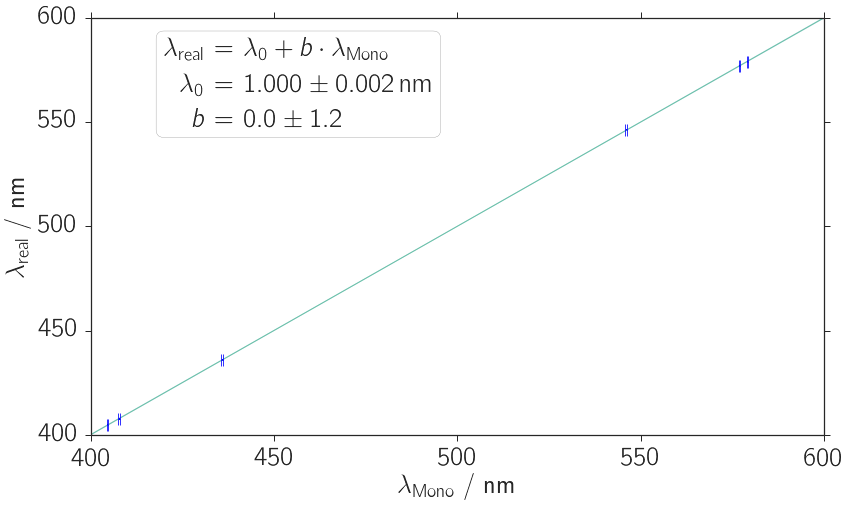

In [33]:
x0 = un.nominal_values(x0s)
s_x0 = un.std_devs(x0s)

lit_peaks = np.array([404.7, 407.8, 435.8, 546.1, 577.1, 579.1])

coeff_lin, cov_lin = curve_fit(linear, lit_peaks, x0, p0=None, 
                               sigma=np.sqrt(s_x0), absolute_sigma=True)
c_lin = uc.correlated_values(coeff_lin, cov_lin)
# Switch to lambda(x0) = lit_peak(x0)
d_lin = np.array([1 / c_lin[0], -c_lin[1] / c_lin[0]])
np.save(npy_dir + 'mono_calibration', d_lin)

# Plotting
x_min, x_max = [400, 600]
x = np.linspace(x_min, x_max, 200)
fit = linear(x, *d_lin)

fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle('Calibration of Monochromator: Linear fit', y=1.02)
ax1.fill_between(x, 
        un.nominal_values(fit) + un.std_devs(fit),
        un.nominal_values(fit) - un.std_devs(fit),
        facecolor=colors[0], color=colors[0], alpha=0.2)
ax1.plot(x, un.nominal_values(fit), '-', linewidth=1.0)  
ax1.errorbar(x0, lit_peaks, xerr=s_x0, yerr=None, fmt='b,', elinewidth=1.0, capsize=6.2, capthick=0.8)
ax1.set_xlim(xlim_global)
ax1.set_ylim(xlim_global)
ax1.set_xlabel("$\lambda_\mathrm{Mono}$ / nm")
ax1.set_ylabel("$\lambda_\mathrm{real}$ / nm")
#ax1.legend(loc=1)

# Get the parameters ofthe linear fit to be presented in a textbox
l0_str = uc_str(d_lin[0])
b_str = uc_str(d_lin[1])
textstr = "\\begin{eqnarray*} \
        \\ \lambda_\mathrm{real} &=& \lambda_0 + b \cdot \lambda_\mathrm{Mono} \\\\ \
        \\ \lambda_0 &=& %s \,\mathrm{nm} \\\\ \
        \\ b &=& %s\
        \end{eqnarray*}"%(l0_str,b_str)
ax1 = plt.gca()
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.1, 0.95, textstr, transform=ax1.transAxes, va='top', bbox=props)

if show_fig:
    fig1.show()
if save_fig:
    file_name = "mono_calibration_linear_fit"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")

### Effects of slit width

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


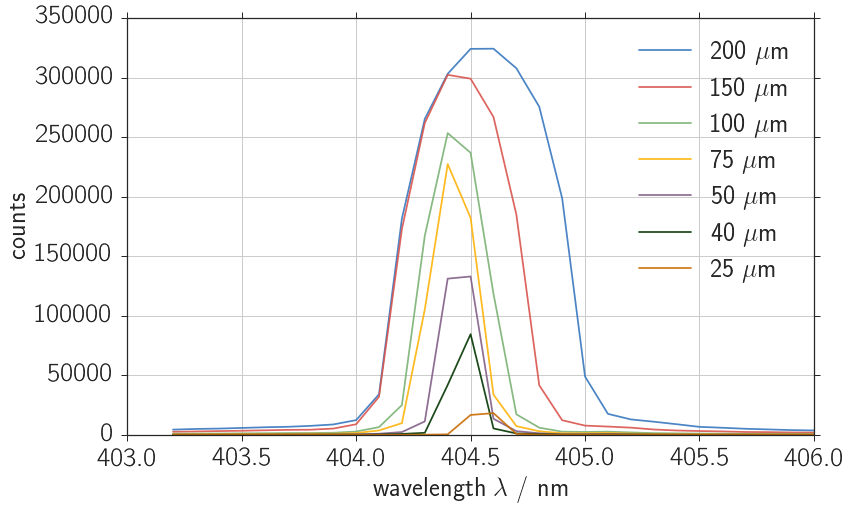

In [34]:
# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('Monochromator: effect of slit width')

widths = [200, 150, 100, 75, 50, 40, 25]
for i, width in enumerate(widths):
    filename = 'mono_slit_' + str(width)
    x = np.load("npy/" + filename + "_lamb.npy") / 10
    x = x[1:]
    y0 = np.load("npy/" + filename + "_count.npy")
    y0 = y0[1:]
    ax.plot(x, y0, '-', c=colors[i], alpha = 0.9, label=(str(width) + ' $\mu$m'))
    # Different style:
    #ax.plot(x, y0, ".", ms=12, c=colors[i], alpha = 0.9, label=(str(width) + ' $\mu$m'))
    #ax.plot(x, y0, "-", c=colors[i], alpha = 0.3)
    
ax.set_xlim(xlim_global)
ax.set_xlim(403, 406)
#ax.set_ylim(0,10000)
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("counts")
ax.grid(True)
ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "mono_slit"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

### No further quantitative analysis needed: Optimal width at 100 $\mu$m, resolution too low anyways. Weak visible offset towards higher wavelength of $\approx 0.2$ nm.

## Boundary of detection for photo multiplier

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


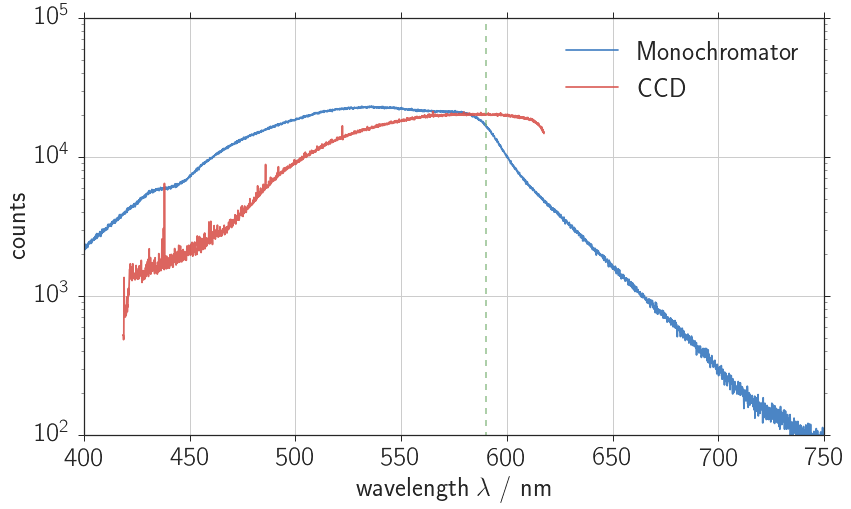

In [35]:
filename = "mono_white_full_01"
x = np.load("npy/"+filename+"_lamb.npy") / 10
x = x[1:]
y = np.load("npy/"+filename+"_count.npy")
y = y[1:]

filename = "ccd_white_00"
x_ccd = np.load("npy/"+filename+"_lamb.npy")
y_ccd = np.load("npy/"+filename+"_count.npy") * 2/5

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('Monochromator: upper boundary of detection')
ax.plot(x, y, "-", c=colors[0], alpha = 0.9, label='Monochromator')
ax.plot(x_ccd, y_ccd, "-", c=colors[1], alpha = 0.9, label='CCD')
ax.plot([590, 590], [1e1, 1e5], "--", c=colors[2], alpha = 0.7)

ax.set_xlim(400, 750)
ax.set_ylim(1e2, 1e5)
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("counts")
ax.grid(True)
ax.legend(loc='best')
ax.set_yscale("log")
#ax.set_xscale("log")

if save_fig:
    file_name = "mono_bound"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

## Detection probability of polarized light

### There is no measurement for 45 deg. Instead, we take the mean and interpolate between 0 and 90 deg, assuming linear dependence...

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


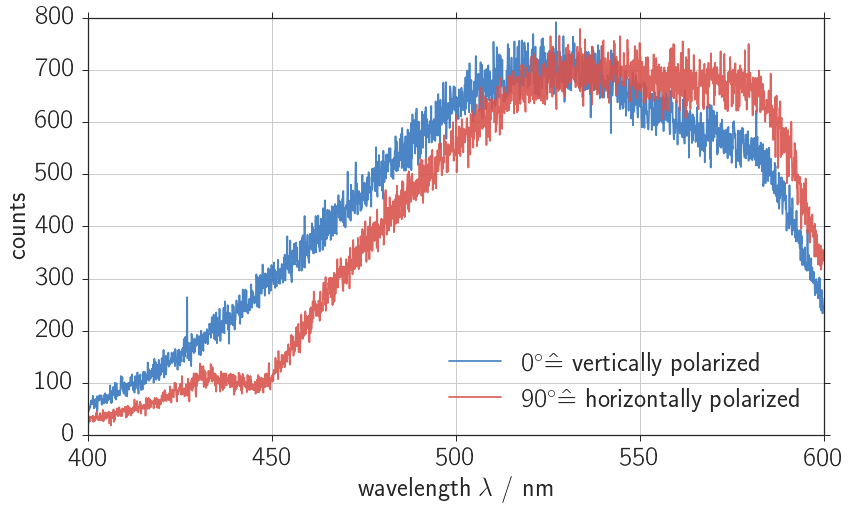

In [36]:
filename = "mono_white_pol0"
x = np.load("npy/"+filename+"_lamb.npy") / 10
x = x[1:]
y0 = np.load("npy/"+filename+"_count.npy")
y0 = y0[1:]

filename = "mono_white_pol90"
y90 = np.load("npy/"+filename+"_count.npy")
y90 = y90[1:]

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('Monochromator: detection probability for polarized light')
ax.plot(x, y0, "-", alpha = 0.9, c=colors[0], label='$0^\# circ \hat{=}$ vertically polarized')
ax.plot(x, y90, "-", alpha = 0.9, c=colors[1], label='$90^\circ \hat{=}$ horizontally polarized')
#ax.plot(x, y45, "-", alpha = 0.9, c=colors[2], label='$45^\circ$')
ax.set_xlim(xlim_global)
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("counts")
ax.grid(True)
ax.legend(loc='best')

if save_fig:
    file_name = "mono_polarized"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

# Spectra with the Monochromator
* ## CS2
* ## CHCl3
* ## CCL4

# CS$_2$

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


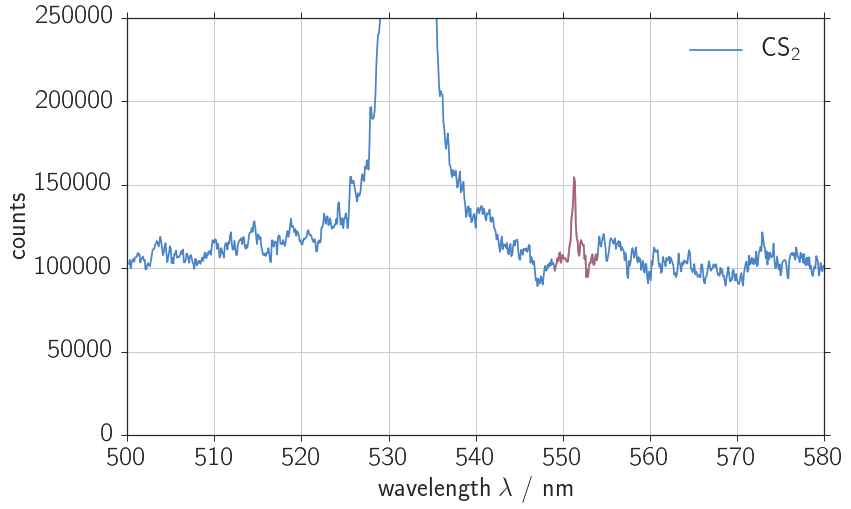

In [37]:
'data/mono_cs2_04.log'
filename = 'mono_cs2_04' # 04: Stokes at 551 nm
x = np.load("npy/"+filename+"_lamb.npy") / 10
x = x[1:]
y = np.load("npy/"+filename+"_count.npy")
y = y[1:]
# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('Monochromator, Spectrum CS$_2$')
ax.plot(x, y, "-", alpha = 0.9, c=colors[0], label='CS$_2$')

x_ranges = [[549, 554]]
labels = ['551.3 nm']
x0s = []
for i, x_range, label in zip(range(len(x_ranges)), x_ranges, labels):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    x0 = x_fit[np.argmax(y_fit)]
    x0s.append(uc.ufloat(x0, sx0_global))
    ax.plot(x_fit, y_fit, "-", alpha = 0.7, c=colors[1])
    
print(x0s, lamb_to_cm(x0s[0]))  

ax.set_xlim(500, 580)
ax.set_ylim(0, 2.5e5)
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("counts")
ax.grid(True)
ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "mono_cs2"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

# CHCl$_3$

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


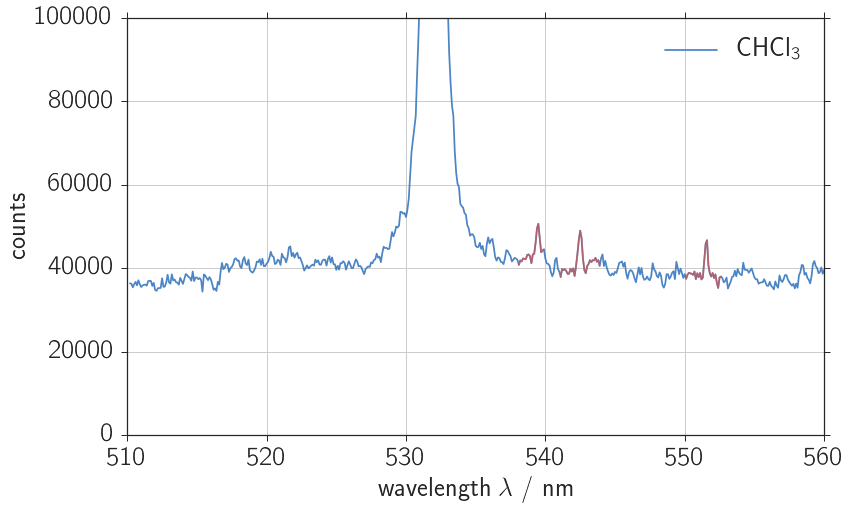

In [38]:
'data/mono_chcl3_04.dig'
filename = 'mono_chcl3_01' # 01 & 02: 3S, 1 AS
x = np.load("npy/"+filename+"_lamb.npy") / 10
x = x[1:]
y = np.load("npy/"+filename+"_count.npy")
y = y[1:]

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('Monochromator, Spectrum CHCl$_3$')
ax.plot(x, y, "-", alpha = 0.9, c=colors[0], label='CHCl$_3$')

x_ranges = [[538, 540], [541, 544], [550, 552.7]]
x0s = []
for x_range in x_ranges:
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    x0 = x_fit[np.argmax(y_fit)]
    x0s.append(uc.ufloat(x0, sx0_global))
    ax.plot(x_fit, y_fit, "-", alpha = 0.7, c=colors[1])


ax.set_xlim(510, 560)
ax.set_ylim(0, 8e3)
ax.set_ylim(0, 1e5)
ax.set_xlabel("wavelength $\lambda$ / nm")        
ax.set_ylabel("counts")
ax.grid(True)
ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "mono_chcl3"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

x0s = np.array(x0s)
lits = np.sort(np.array([680, 366, 260]))
i=0
for x0, dnu_cm, lit in zip(x0s, lamb_to_cm(x0s), lits):
    i += 1
    print("\cellcolor{LightCyan}$%i$ & $%s$ & $%s$ & $%i$   \\\\"%(
            i, uc_str(x0), uc_str(dnu_cm), lit))

# CCl$_4$

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


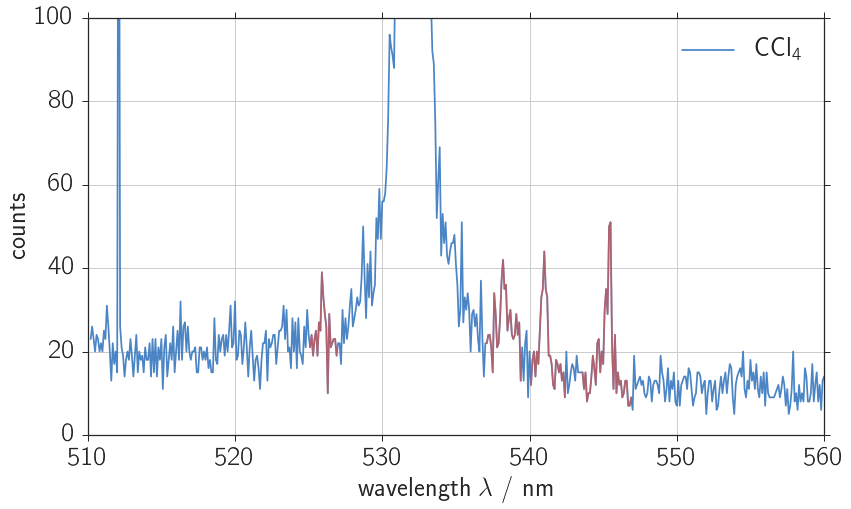

In [39]:
'data/mono_ccl4_00.dat'
filename = "mono_ccl4_01"
#filename = "mono_ccl4_overnight"
# Relevant peaks are visible in both measurements...
x = np.load("npy/"+filename+"_lamb.npy") / 10
x = x[1:]
y = np.load("npy/"+filename+"_count.npy")
y = y[1:]

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('Monochromator, Spectrum CCl$_4$')
ax.plot(x, y, "-", alpha = 0.9, c=colors[0], label='CCl$_4$')

x_ranges = [[525, 527], [537, 539.5], [540, 542.5], [543.5, 547]]
labels = ['551.3 nm']
x0s = []
for x_range in x_ranges:
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    x0 = x_fit[np.argmax(y_fit)]
    x0s.append(uc.ufloat(x0, sx0_global))
    ax.plot(x_fit, y_fit, "-", alpha = 0.7, c=colors[1])
x0s = np.array(x0s)
lits = np.sort(np.array([459, 217, 217, 314]))
i=0
for x0, dnu_cm, lit in zip(x0s, lamb_to_cm(x0s), lits):
    i += 1
    print("\cellcolor{LightCyan}$%i$ & $%s$ & $%s$ & $%i$   \\\\"%(
            i, uc_str(x0), uc_str(dnu_cm), lit))
    
ax.set_xlim(510, 560)
ax.set_ylim(0, 0.1e3)
#ax.set_ylim(0, 0.2e6)
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("counts")
ax.grid(True)
ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "mono_ccl4"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

### Literatur peaks are visible:

In [192]:
lits = np.sort(np.array([459, 217, 217, 314]))
i=0
for x0, dnu_cm, lit in zip(x0s, lamb_to_cm(x0s), lits):
    i += 1
    print("\cellcolor{LightCyan}$%i$ & $%s$ & $%s$ & $%i$   \\\\"%(
            i, uc_str(x0), uc_str(dnu_cm), lit))

\cellcolor{LightCyan}$1$ & $525.9 \pm 0.2$ & $222 \pm 12$ & $217$   \\
\cellcolor{LightCyan}$2$ & $538.2 \pm 0.2$ & $212 \pm 12$ & $217$   \\
\cellcolor{LightCyan}$3$ & $541.0 \pm 0.2$ & $309 \pm 11$ & $314$   \\
\cellcolor{LightCyan}$4$ & $545.5 \pm 0.2$ & $461 \pm 11$ & $459$   \\
